In [ ]:
!pip install autogluon

In [ ]:
# Import modules
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Categorical, Real, Int


In [ ]:
# Load and prepare data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["target"])

In [ ]:
# Split data (70% train, 10% val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [ ]:
# Defining Model
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
# Manual Training
def manual_train(batch_size, lr, epochs):
    model = IrisNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to tensors
    X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.long)

    # Store training history
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            outputs = model(X_tensor[i:i+batch_size])
            loss = criterion(outputs, y_tensor[i:i+batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history['train_loss'].append(epoch_loss/len(X_train))

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, torch.tensor(y_val.values.flatten(), dtype=torch.long))
            history['val_loss'].append(val_loss.item())

    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
        test_preds = torch.argmax(test_outputs, 1).numpy()

    return {
        'metrics': (accuracy_score(y_test, test_preds),
                   f1_score(y_test, test_preds, average='weighted')),
        'history': history,
        'model': model,
        'preds': test_preds
    }


In [ ]:
# Run manual search
manual_results = []
configs = [(bs, lr, ep) for bs in [2,4] for lr in [1e-3,1e-5] for ep in [1,3,5]]

for bs, lr, ep in configs:
    result = manual_train(bs, lr, ep)
    manual_results.append({
        'batch_size': bs,
        'lr': lr,
        'epochs': ep,
        'accuracy': result['metrics'][0],
        'f1': result['metrics'][1],
        'history': result['history'],
        'model': result['model'],
        'preds': result['preds']
    })

# Create comparison dataframe
manual_df = pd.DataFrame(manual_results)

In [ ]:
# Performance for each hyperparameter combination over accuracy and F1.
acc_f1_df = pd.DataFrame([
    {
        'Batch Size': res['batch_size'],
        'Learning Rate': f"{res['lr']:.0e}",
        'Epochs': res['epochs'],
        'Accuracy': res['accuracy'],
        'F1 Score': res['f1']
    }
    for res in manual_results
])

print("\nHyperparameter Results Summary:")
acc_f1_df


Hyperparameter Results Summary:


,Batch Size,Learning Rate,Epochs,Accuracy,F1 Score
0,2,1e-03,1,0.366667,0.260215
1,2,1e-03,3,0.700000,0.593548
2,2,1e-03,5,0.733333,0.662222
3,2,1e-05,1,0.366667,0.196748
4,2,1e-05,3,0.366667,0.196748
5,2,1e-05,5,0.200000,0.138462
6,4,1e-03,1,0.000000,0.000000
7,4,1e-03,3,0.366667,0.260215
8,4,1e-03,5,0.700000,0.593548
9,4,1e-05,1,0.300000,0.138462


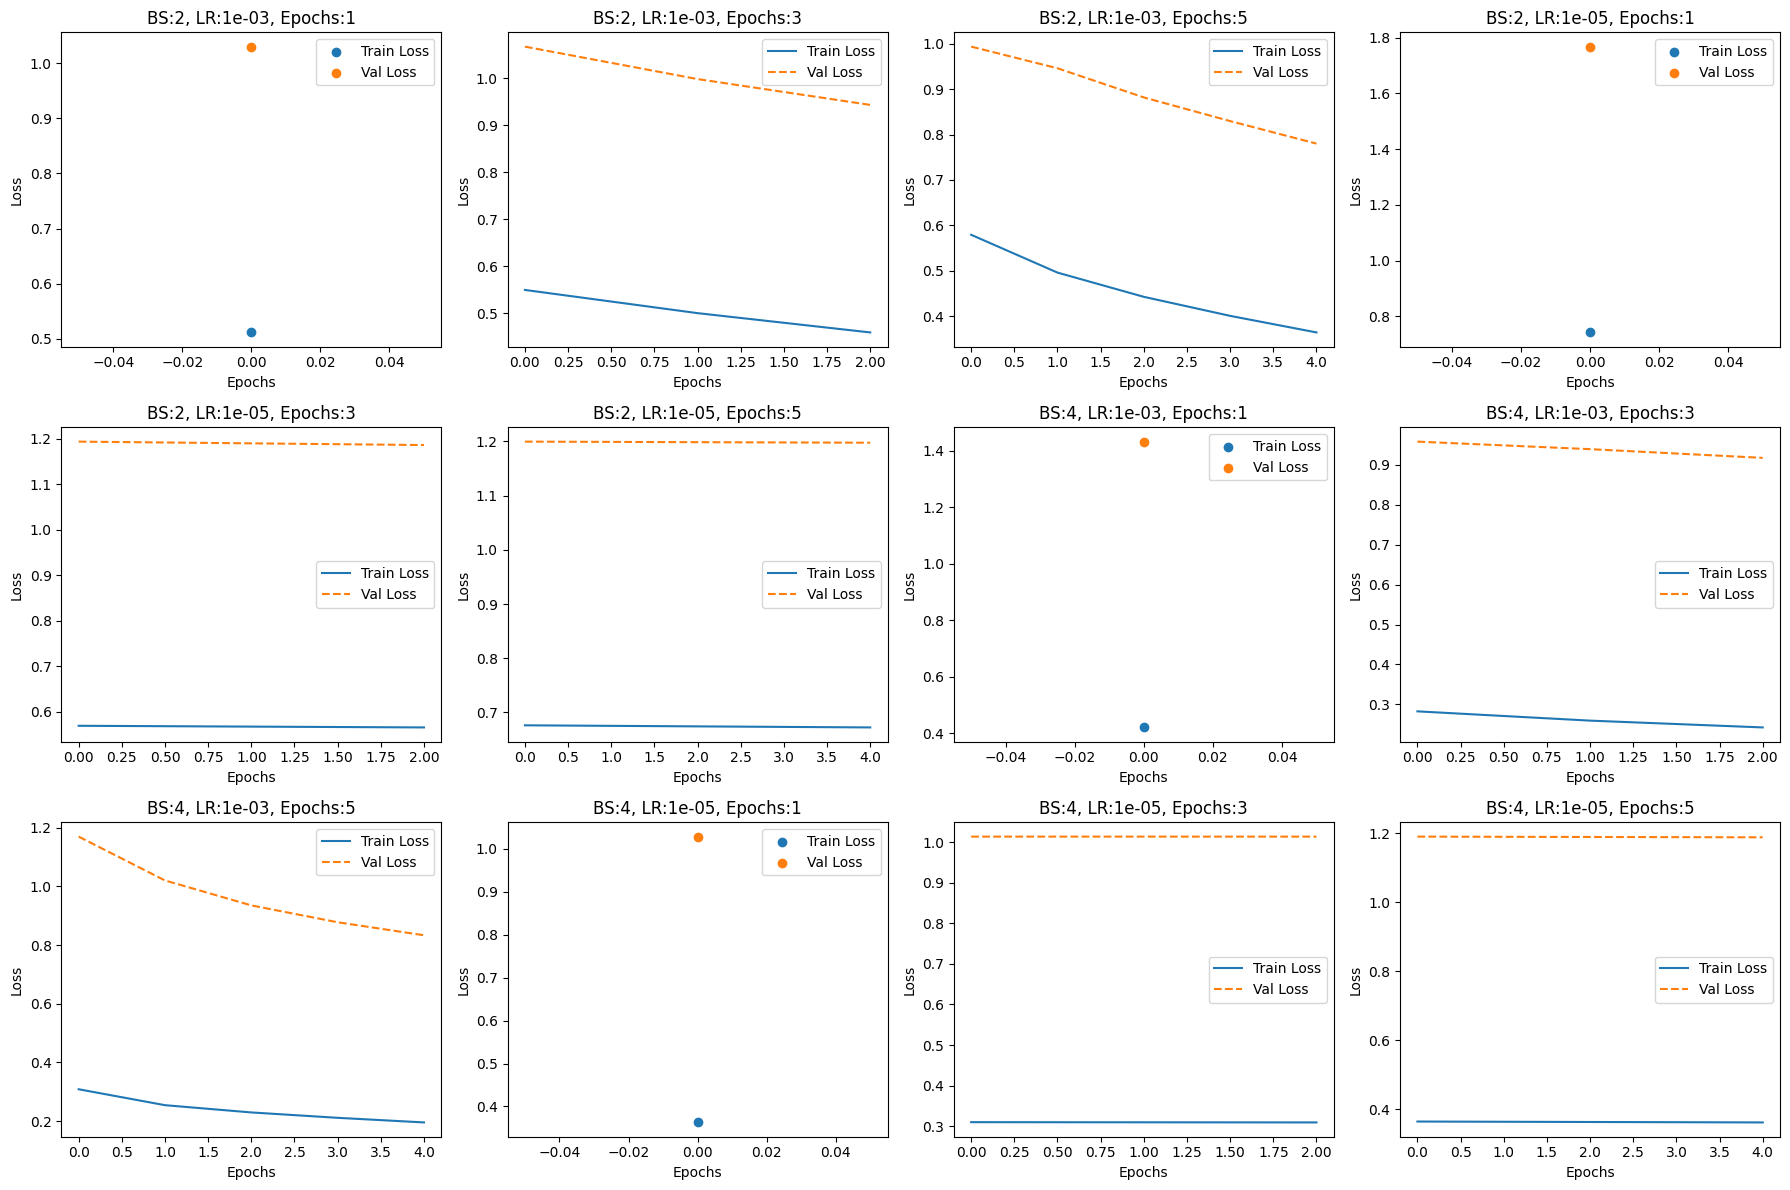

In [ ]:
# Validation and Training Loss curves
plt.figure(figsize=(18, 12))

num_results = len(manual_results)

for i, res in enumerate(manual_results):
    if res['epochs'] == 1:
        plt.subplot(3, 4, i + 1)
        label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

        plt.scatter([0], res['history']['train_loss'], label='Train Loss')  # Scatter plot for only 1 epoch
        plt.scatter([0], res['history']['val_loss'], label='Val Loss')  # Scatter plot for only 1 epoch

        plt.title(label)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        continue

    plt.subplot(3, 4, i + 1)
    label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

    plt.plot(res['history']['train_loss'], label='Train Loss')
    plt.plot(res['history']['val_loss'], '--', label='Val Loss')

    plt.title(label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()

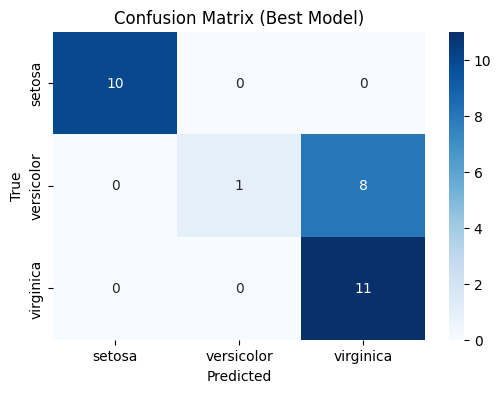

In [ ]:
# Plot confusion matrix for best model
best_model = manual_df.loc[manual_df['f1'].idxmax()]
cm = confusion_matrix(y_test, best_model['preds'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=data.target_names,
           yticklabels=data.target_names)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

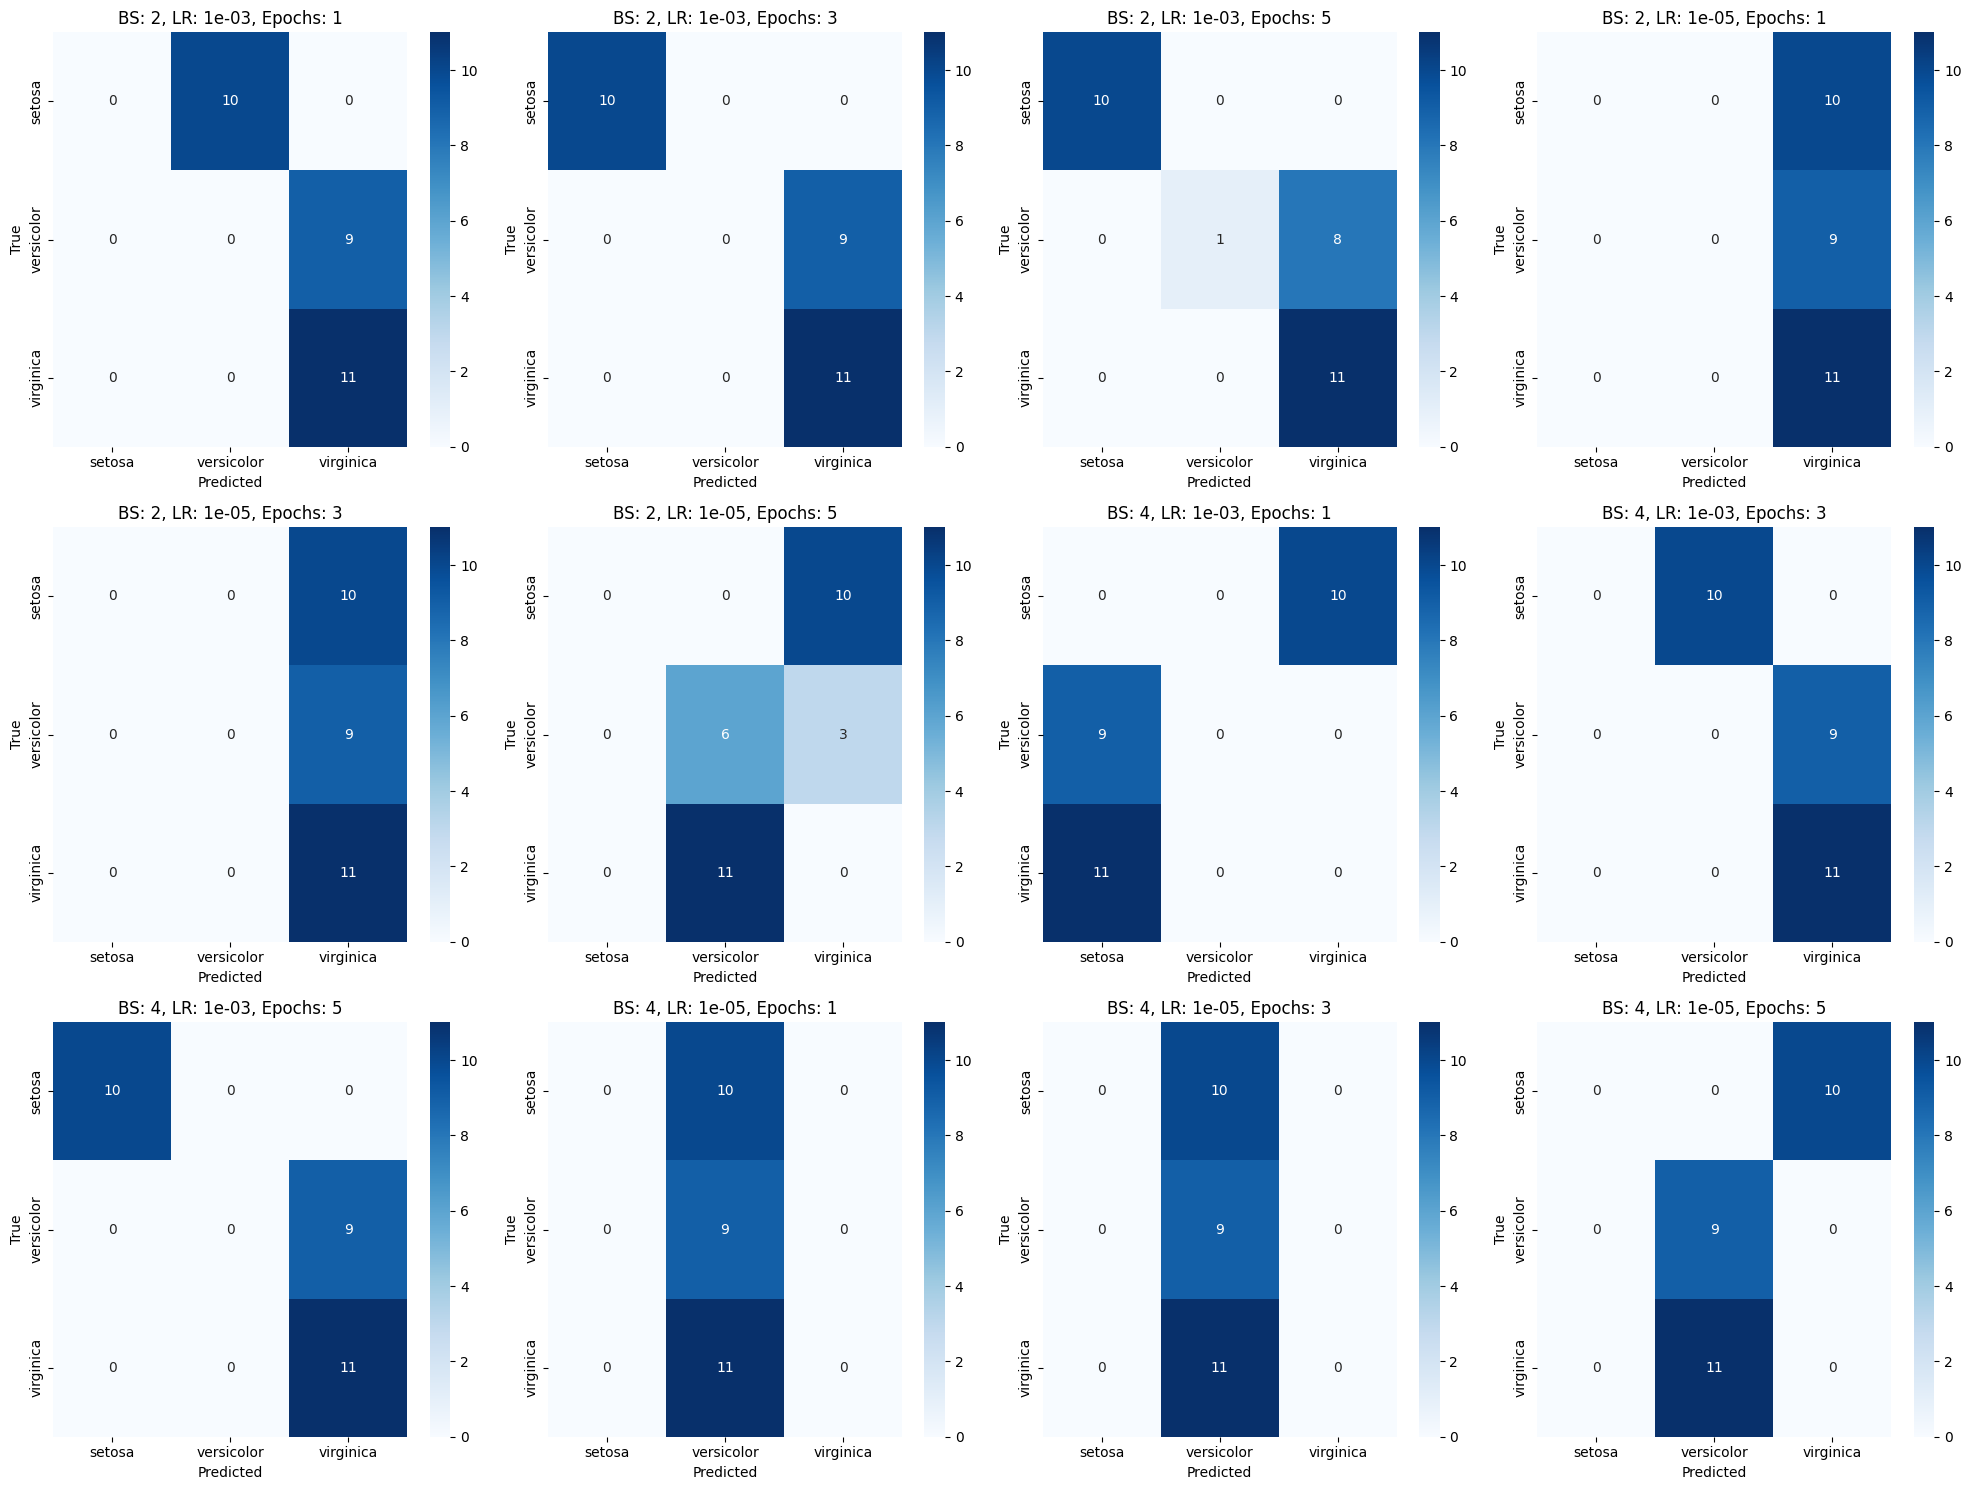

In [ ]:
# Plot confusion matrices for all hyperparameter combinations
rows = 3
cols = 4

plt.figure(figsize=(cols * 5, rows * 5))

# Loop through each model result
for i, res in enumerate(manual_results):
    cm = confusion_matrix(y_test, res['preds'])

    plt.subplot(rows, cols, i + 1)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=data.target_names,
                yticklabels=data.target_names)

    plt.title(f"BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

In [ ]:
# Show 5 sample predictions for best model
sample_idx = np.random.choice(len(X_test), 5, replace=False)
print("\nSample Predictions:")
for idx in sample_idx:
    features = X_test.iloc[idx].values
    true = data.target_names[y_test.iloc[idx].values[0]]
    pred = data.target_names[best_model['preds'][idx]]
    print(f"Features: {features} | Predicted: {pred:8} | True: {true}")


Sample Predictions:
Features: [6.8 3.2 5.9 2.3] | Predicted: virginica | True: virginica
Features: [6.  2.9 4.5 1.5] | Predicted: virginica | True: versicolor
Features: [6.5 3.  5.8 2.2] | Predicted: virginica | True: virginica
Features: [6.1 2.8 4.7 1.2] | Predicted: virginica | True: versicolor
Features: [6.5 3.2 5.1 2. ] | Predicted: virginica | True: virginica


In [ ]:
# Show 5 sample predictions for each model
print("\nSample Predictions for Each Model:\n")

for res in manual_results:
    print(f"\nModel - BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}\n")

    # Randomly select 5 test samples
    sample_idx = np.random.choice(len(X_test), 5, replace=False)

    for idx in sample_idx:
        features = X_test.iloc[idx].values
        true = data.target_names[y_test.iloc[idx].values[0]]
        pred = data.target_names[res['preds'][idx]]

        print(f"Features: {features} | Predicted: {pred:12} | True: {true}")



Sample Predictions for Each Model:


Model - BS: 2, LR: 1e-03, Epochs: 1

Features: [6.5 3.  5.8 2.2] | Predicted: virginica    | True: virginica
Features: [6.7 2.5 5.8 1.8] | Predicted: virginica    | True: virginica
Features: [4.8 3.1 1.6 0.2] | Predicted: versicolor   | True: setosa
Features: [5.6 2.9 3.6 1.3] | Predicted: virginica    | True: versicolor
Features: [5.1 3.8 1.5 0.3] | Predicted: versicolor   | True: setosa

Model - BS: 2, LR: 1e-03, Epochs: 3

Features: [5.  3.4 1.6 0.4] | Predicted: setosa       | True: setosa
Features: [6.1 3.  4.9 1.8] | Predicted: virginica    | True: virginica
Features: [7.9 3.8 6.4 2. ] | Predicted: virginica    | True: virginica
Features: [6.8 2.8 4.8 1.4] | Predicted: virginica    | True: versicolor
Features: [6.3 3.3 4.7 1.6] | Predicted: virginica    | True: versicolor

Model - BS: 2, LR: 1e-03, Epochs: 5

Features: [4.7 3.2 1.6 0.2] | Predicted: setosa       | True: setosa
Features: [6.7 3.  5.2 2.3] | Predicted: virginica    | True: virg

In [ ]:
# Autogluon Search
def run_autogluon_search(method):
    try:
        hyperparams = {
            'NN_TORCH': {
                'num_epochs': Int(1,5),
                'learning_rate': Real(1e-5,1e-3),
                'batch_size': Categorical(2,4)
            }
        }

        path = f"{method}_model"
        if os.path.exists(path):
            shutil.rmtree(path)

        predictor = TabularPredictor(
            label="target",
            path=path,
            eval_metric='f1_weighted'
        ).fit(
            train_data=pd.concat([X_train, y_train], axis=1),
            tuning_data=pd.concat([X_val, y_val], axis=1),
            hyperparameters=hyperparams,
            hyperparameter_tune_kwargs={
                'num_trials': 5,
                'searcher': method,
                'scheduler': 'local'
            },
            time_limit=300
        )

        test_pred = predictor.predict(pd.concat([X_test, y_test], axis=1))
        return {
            'accuracy': accuracy_score(y_test, test_pred),
            'f1': f1_score(y_test, test_pred, average='weighted')
        }
    except Exception as e:
        print(f"{method} search failed: {str(e)}")
        return {'accuracy':0, 'f1':0}


In [ ]:
# Random Search
random_result = run_autogluon_search('random')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.55 GB / 12.67 GB (83.2%)
Disk Space Avail:   73.52 GB / 107.72 GB (68.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spe

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch        |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 5                     |
+--------------------------------------------------------+

View detailed results here: /content/random_model/models/NeuralNetTorch


Fitted model: NeuralNetTorch/212e8_00000 ...
	0.7916	 = Validation score   (f1_weighted)
	6.13s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/212e8_00001 ...
	0.9348	 = Validation score   (f1_weighted)
	6.4s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch/212e8_00002 ...
	0.8042	 = Validation score   (f1_weighted)
	8.6s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch/212e8_00003 ...
	0.7916	 = Validation score   (f1_weighted)
	6.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/212e8_00004 ...
	0.5825	 = Validation score   (f1_weighted)
	4.26s	 = Training   runtime
	0.0s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.93s of the 248.98s of remaining time.
	Ensemble Weights: {'NeuralNetTorch/212e8_00001': 1.0}
	0.9348	 = Validation score   (f1_weighted)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 51.07s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 2228.6 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/random_model")


In [ ]:
# Bayesian Optimization
bayes_result = run_autogluon_search('bayes')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.08 GB / 12.67 GB (79.5%)
Disk Space Avail:   73.49 GB / 107.72 GB (68.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spe

+---------------------------------------------------+
| Configuration for experiment     NeuralNetTorch   |
+---------------------------------------------------+
| Search algorithm                 SearchGenerator  |
| Scheduler                        FIFOScheduler    |
| Number of trials                 5                |
+---------------------------------------------------+

View detailed results here: /content/bayes_model/models/NeuralNetTorch


Fitted model: NeuralNetTorch/6867da17 ...
	0.7916	 = Validation score   (f1_weighted)
	6.13s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/abf5c38e ...
	0.8705	 = Validation score   (f1_weighted)
	6.7s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/c30f6f5b ...
	0.8705	 = Validation score   (f1_weighted)
	5.64s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch/5ebe5940 ...
	0.9348	 = Validation score   (f1_weighted)
	10.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/30c8aab2 ...
	0.8705	 = Validation score   (f1_weighted)
	5.01s	 = Training   runtime
	0.01s	 = Validation runtime


Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.94s of the 259.44s of remaining time.
	Ensemble Weights: {'NeuralNetTorch/5ebe5940': 1.0}
	0.9348	 = Validation score   (f1_weighted)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 40.59s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 1558.3 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/bayes_model")


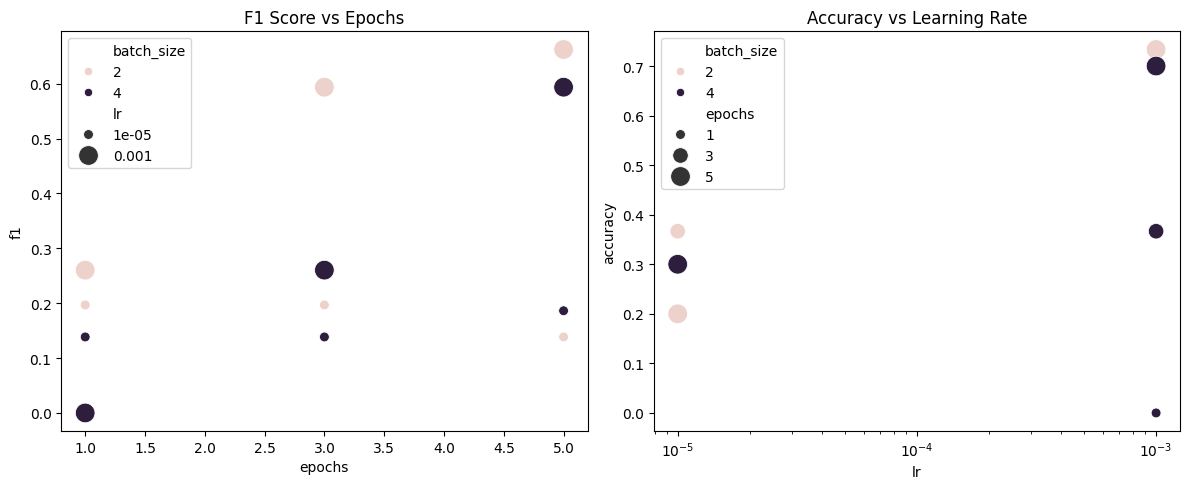

In [ ]:
# Scatterplot
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.scatterplot(data=manual_df, x='epochs', y='f1', hue='batch_size', size='lr', sizes=(50,200))
plt.title("F1 Score vs Epochs")
plt.subplot(122)
sns.scatterplot(data=manual_df, x='lr', y='accuracy', hue='batch_size', size='epochs', sizes=(50,200))
plt.xscale('log')
plt.title("Accuracy vs Learning Rate")
plt.tight_layout()
plt.show()

In [ ]:
# Final Comparison
comparison_data = {
    'Method': ['Manual Grid Search', 'Random Search', 'Bayesian Search'],
    'Accuracy': [manual_df['accuracy'].max(), random_result['accuracy'], bayes_result['accuracy']],
    'F1 Score': [manual_df['f1'].max(), random_result['f1'], bayes_result['f1']]
}
results_df = pd.DataFrame(comparison_data)
print("\nFinal Comparison:")
results_df


Final Comparison:


,Method,Accuracy,F1 Score
0,Manual Grid Search,0.733333,0.662222
1,Random Search,0.933333,0.933333
2,Bayesian Search,0.900000,0.899248


# Theoretical Analysis

1. Epochs vs Performance: Generally direct relationship - more epochs allow better learning
2. Batch Size vs Performance: Inverse relationship - smaller batches provide more updates
3. Learning Rate: Optimal mid-range values perform best (1e-3 better than 1e-5 here)
4. Automated vs Manual: Automated search better - explores wider hyperparameter space efficiently
5. Best Approach: Bayesian optimization performs best, combining exploration/exploitation